[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/hpo/hpo_general.ipynb)

[![View Source on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/hpo/hpo_general.ipynb)

## HPO for any model

So far we have been optimizing hyperparameters of machine/deep learning models which have been built using ``Model`` class of ai4water. However, the ``HyperOpt`` class of ai4water is quite general and it can be used to optimize hyperparaemters of any machine learning model or infact any model as far as we can define the objective function for it and evaluate it. This notebook shows the optimization of a machine learning model which is not built using ``Model`` class of ai4water. This notebook is presented so that the user can easily adopt it to optimize hyperparameters of their models which are not built using ``Model`` class of ai4water.

In [1]:
try:
    import ai4water
except (ImportError, ModuleNotFoundError):
    !pip install ai4water[hpo]

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ai4water: filename=AI4Water-1.6-py3-none-any.whl size=591181 sha256=5c1341df790674270d642ee0fc2237f3c1006fe214e9cde6fbb21de3b8825fac
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\2a\b1\52\2dd947d11127f0bddfd30d7772ddbd414b1be00605b9fc1af2
Successfully built ai4water


In [2]:
import site
site.addsitedir("D:\\mytools\\AI4Water")


In [28]:
import os
import math

import numpy as np
 
import xgboost as xgb
    
from ai4water.datasets import ecoli_mekong
from ai4water.utils.utils import get_version_info
from ai4water.hyperopt import HyperOpt
from ai4water.preprocessing import DataSet
from ai4water.hyperopt import Categorical, Real, Integer
from ai4water.utils.utils import dateandtime_now, jsonize, TrainTestSplit

from SeqMetrics import RegressionMetrics

In [4]:
# print the version of all the underlying libraries to increase reproducibility and transparancy

for k,v in get_version_info().items():
    print(f"{k} version: {v}")

python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:16) [MSC v.1916 64 bit (AMD64)]
os version: nt
ai4water version: 1.06
lightgbm version: 3.3.1
tcn version: 3.4.0
catboost version: 0.26
xgboost version: 1.5.0
easy_mpl version: 0.21.3
SeqMetrics version: 1.3.3
tensorflow version: 2.7.0
keras.api._v2.keras version: 2.7.0
numpy version: 1.21.0
pandas version: 1.3.4
matplotlib version: 3.4.3
h5py version: 3.5.0
sklearn version: 1.0.1
shapefile version: 2.3.0
fiona version: 1.8.22
xarray version: 0.20.1
netCDF4 version: 1.5.7
optuna version: 2.10.1
skopt version: 0.9.0
hyperopt version: 0.2.7
plotly version: 5.3.1
lime version: NotDefined
seaborn version: 0.11.2


In [5]:
data = ecoli_mekong()

0% of 0.05 MB downloaded
100% of 0.05 MB downloaded


Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


0% of 0.01 MB downloaded
100% of 0.01 MB downloaded
0% of 0.15 MB downloaded
100% of 0.15 MB downloaded


In [6]:
data.shape

(1602, 10)

In [7]:
data.isna().sum()

station_name           0
T                     72
EC                    77
DOpercent            192
DO                   252
pH                   191
ORP                  349
Turbidity             63
TSS                  269
E-coli_4dilutions     58
dtype: int64

In [8]:
data.head()

,station_name,T,EC,DOpercent,DO,pH,ORP,Turbidity,TSS,E-coli_4dilutions
Date_Time,,,,,,,,,,
2011-05-25 10:00:00,Houay Pano,24.11,273.0,87.5,7.34,7.67,53.5,13.47,NaN,NaN
2011-05-25 16:40:00,Houay Pano,NaN,NaN,NaN,NaN,NaN,NaN,1380.00,0.899281,1100.0
2011-05-25 17:06:00,Houay Pano,NaN,NaN,NaN,NaN,NaN,NaN,1116.00,0.993190,1400.0
2011-05-25 17:10:00,Houay Pano,NaN,NaN,NaN,NaN,NaN,NaN,1392.00,1.107880,NaN
2011-05-25 17:24:00,Houay Pano,NaN,NaN,NaN,NaN,NaN,NaN,702.00,1.325030,14000.0


In [9]:
data.columns

Index(['station_name', 'T', 'EC', 'DOpercent', 'DO', 'pH', 'ORP', 'Turbidity',
       'TSS', 'E-coli_4dilutions'],
      dtype='object')

In [10]:
data = data.dropna().iloc[:, 1:]
data.shape

(982, 9)

In [11]:
splitter = TrainTestSplit()

TrainX, TestX, TrainY, TestY = splitter.split_by_random(data.iloc[:, 0:-1].values, data.iloc[:, -1].values)

TrainX.shape, TrainY.shape, TestX.shape, TestY.shape

((687, 8), (687,), (295, 8), (295,))

In [12]:
train_x, val_x, train_y, val_y = splitter.split_by_random(TrainX, TrainY)

train_x.shape, train_y.shape, val_x.shape, val_y.shape

((480, 8), (480,), (207, 8), (207,))

In [13]:
dTrain = xgb.DMatrix(TrainX, label=TrainY)

dTest = xgb.DMatrix(TestX, label=TestY)

In [14]:
evallist = [(dTrain, 'train'), (dTest, 'eval')]

In [64]:
param = {'max_depth': 6, 'verbosity': 0}

num_round = 10

bst = xgb.train(param, dTrain, num_round, evallist)

[0]	train-rmse:8306.48535	eval-rmse:12248.90234
[1]	train-rmse:6981.59473	eval-rmse:12072.32227
[2]	train-rmse:5918.43164	eval-rmse:11966.04883
[3]	train-rmse:5081.06934	eval-rmse:11895.01562
[4]	train-rmse:4352.86865	eval-rmse:11900.93066
[5]	train-rmse:3740.82105	eval-rmse:11888.00977
[6]	train-rmse:3266.69653	eval-rmse:11873.17481
[7]	train-rmse:2845.99390	eval-rmse:11808.76562
[8]	train-rmse:2446.77612	eval-rmse:11826.59082
[9]	train-rmse:2166.21191	eval-rmse:11822.69727


In [65]:
prediction = bst.predict(dTest)

In [66]:
RegressionMetrics(TestY, prediction).r2()

0.08759845832207207

In [67]:
RegressionMetrics(TestY, prediction).nse()

0.08548456196040655

In [69]:
RegressionMetrics(TestY, prediction).rmse()

11822.697119290622

In [20]:
dtrain = xgb.DMatrix(train_x, label=train_y)

dval = xgb.DMatrix(val_x, label=val_y)

In [29]:
num_iterations = 100
SEP = os.sep

In [45]:

VAL_SCORES = []
ITER = 0

def objective_fn(
    **suggestions
)->float:
    """
    This function must build, train and evaluate the ML model.
    The output of this function will be minimized by optimization algorithm.
    """
    suggestions = jsonize(suggestions)
    global ITER

    # build and train model
    num_rounds = suggestions.pop('n_estimators')
    evallist = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(suggestions, dtrain, num_rounds, evallist)

    # evaluate model
    prediction = bst.predict(dval)
    val_score_ = RegressionMetrics(val_y, prediction).nse()
    
    if not math.isfinite(val_score_):
        val_score_ = -9999

    # since the optimization algorithm solves minimization algorithm
    # we have to subtract r2_score from 1.0
    # if our validation metric is something like mse or rmse,
    # then we don't need to subtract it from 1.0
    val_score = 1.0 - val_score_

    VAL_SCORES.append(val_score)
    best_score = round(np.nanmin(VAL_SCORES), 2)
    bst_iter = np.argmin(VAL_SCORES)
    
    ITER += 1

    print(f"{ITER} {round(val_score, 2)} {round(val_score_, 2)}. Best was {best_score} at {bst_iter}")
    
    return val_score

In [50]:
param_space = [
    Integer(low=5, high=100, name='n_estimators', num_samples=10),
    Integer(low=0, high=10, name='gamma', num_samples=10),
    Real(low=0.1, high=0.7, name='eta', num_samples=10),
    Integer(low=2, high=20, name='max_depth', num_samples=10),
    Integer(low=0, high=15, name='min_child_weight', num_samples=10),
    Integer(low=0, high=5, name='max_delta_step', num_samples=10),
    Real(low=0.0, high=1.0, name='subsample', num_samples=10),
    Integer(low=1, high=5, name='lambda', num_samples=10),
    Integer(low=0, high=5, name='alpha', num_samples=10),
    Integer(low=0, high=100, name='max_leaves', num_samples=10),
]

In [54]:
x0 = [10, 0, 0.3, 6, 1, 1, 1, 1, 0, 0]

In [55]:
optimizer = HyperOpt(
    algorithm="bayes",
    objective_fn=objective_fn,
    param_space=param_space,
    x0=x0,
    num_iterations=num_iterations,
    process_results=False,  # we can turn it False if we want post-processing of results
)

In [56]:
results = optimizer.fit()

[0]	train-rmse:10360.37500	eval-rmse:8679.37598
[1]	train-rmse:10360.32129	eval-rmse:8679.28125
[2]	train-rmse:10360.26758	eval-rmse:8679.18750
[3]	train-rmse:10360.21387	eval-rmse:8679.09375
[4]	train-rmse:10360.15820	eval-rmse:8678.99902
[5]	train-rmse:10360.10352	eval-rmse:8678.90527
[6]	train-rmse:10360.04981	eval-rmse:8678.81055
[7]	train-rmse:10359.99512	eval-rmse:8678.71680
[8]	train-rmse:10359.94141	eval-rmse:8678.62305
[9]	train-rmse:10359.88477	eval-rmse:8678.52930
3 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.30469	eval-rmse:8679.25000
[1]	train-rmse:10360.17676	eval-rmse:8679.03027
[2]	train-rmse:10360.04981	eval-rmse:8678.80957
[3]	train-rmse:10359.92285	eval-rmse:8678.58984
[4]	train-rmse:10359.79492	eval-rmse:8678.37012
[5]	train-rmse:10359.66797	eval-rmse:8678.15137
[6]	train-rmse:10359.54102	eval-rmse:8677.93164
[7]	train-rmse:10359.41504	eval-rmse:8677.71094
[8]	train-rmse:10359.28809	eval-rmse:8677.49219
[9]	train-rmse:10359.16113	eval-rmse:8677.27148
[10]	tra

[18]	train-rmse:10358.62793	eval-rmse:8676.34668
[19]	train-rmse:10358.53223	eval-rmse:8676.18359
[20]	train-rmse:10358.43848	eval-rmse:8676.01953
[21]	train-rmse:10358.34375	eval-rmse:8675.85644
[22]	train-rmse:10358.25098	eval-rmse:8675.69141
[23]	train-rmse:10358.15625	eval-rmse:8675.52734
[24]	train-rmse:10358.05957	eval-rmse:8675.36328
[25]	train-rmse:10357.96387	eval-rmse:8675.19922
[26]	train-rmse:10357.87109	eval-rmse:8675.03516
[27]	train-rmse:10357.77539	eval-rmse:8674.87109
[28]	train-rmse:10357.68164	eval-rmse:8674.70801
[29]	train-rmse:10357.58691	eval-rmse:8674.54492
[30]	train-rmse:10357.49316	eval-rmse:8674.38086
[31]	train-rmse:10357.39941	eval-rmse:8674.21680
[32]	train-rmse:10357.30469	eval-rmse:8674.05371
[33]	train-rmse:10357.21094	eval-rmse:8673.88867
[34]	train-rmse:10357.11621	eval-rmse:8673.72559
[35]	train-rmse:10357.02246	eval-rmse:8673.56250
[36]	train-rmse:10356.92773	eval-rmse:8673.39844
[37]	train-rmse:10356.83398	eval-rmse:8673.23438
[38]	train-rmse:1035

[13]	train-rmse:10357.67188	eval-rmse:8674.69043
[14]	train-rmse:10357.47559	eval-rmse:8674.35156
[15]	train-rmse:10357.28027	eval-rmse:8674.00879
[16]	train-rmse:10357.08301	eval-rmse:8673.66992
[17]	train-rmse:10356.88867	eval-rmse:8673.32910
[18]	train-rmse:10356.69238	eval-rmse:8672.99023
[19]	train-rmse:10356.49707	eval-rmse:8672.64941
[20]	train-rmse:10356.30078	eval-rmse:8672.30957
[21]	train-rmse:10356.10547	eval-rmse:8671.97070
[22]	train-rmse:10355.90918	eval-rmse:8671.63086
[23]	train-rmse:10355.71484	eval-rmse:8671.29199
[24]	train-rmse:10355.52148	eval-rmse:8670.95215
[25]	train-rmse:10355.32519	eval-rmse:8670.61328
[26]	train-rmse:10355.13086	eval-rmse:8670.27441
[27]	train-rmse:10354.93457	eval-rmse:8669.93555
[28]	train-rmse:10354.74121	eval-rmse:8669.59668
[29]	train-rmse:10354.54590	eval-rmse:8669.25879
[30]	train-rmse:10354.35156	eval-rmse:8668.91992
[31]	train-rmse:10354.15723	eval-rmse:8668.58203
[32]	train-rmse:10353.96387	eval-rmse:8668.24316
[33]	train-rmse:1035

[25]	train-rmse:10355.11523	eval-rmse:8670.24805
[26]	train-rmse:10355.11523	eval-rmse:8670.24805
[27]	train-rmse:10354.91309	eval-rmse:8669.89551
[28]	train-rmse:10354.70996	eval-rmse:8669.54199
[29]	train-rmse:10354.50488	eval-rmse:8669.19043
[30]	train-rmse:10354.30566	eval-rmse:8668.83691
[31]	train-rmse:10354.30566	eval-rmse:8668.83691
[32]	train-rmse:10354.30566	eval-rmse:8668.83691
[33]	train-rmse:10354.10254	eval-rmse:8668.48438
[34]	train-rmse:10353.89941	eval-rmse:8668.13281
[35]	train-rmse:10353.69629	eval-rmse:8667.78027
[36]	train-rmse:10353.49512	eval-rmse:8667.42871
[37]	train-rmse:10353.29297	eval-rmse:8667.07617
[38]	train-rmse:10353.09277	eval-rmse:8666.72461
[39]	train-rmse:10352.88965	eval-rmse:8666.37305
[40]	train-rmse:10352.68750	eval-rmse:8666.02148
[41]	train-rmse:10352.48633	eval-rmse:8665.67090
[42]	train-rmse:10352.28711	eval-rmse:8665.31934
[43]	train-rmse:10352.08594	eval-rmse:8664.96875
[44]	train-rmse:10351.88379	eval-rmse:8664.61816
[45]	train-rmse:1035

[24]	train-rmse:10355.33887	eval-rmse:8670.64356
[25]	train-rmse:10355.13769	eval-rmse:8670.29199
16 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.32812	eval-rmse:8679.29297
[1]	train-rmse:10360.22656	eval-rmse:8679.11426
[2]	train-rmse:10360.12305	eval-rmse:8678.93750
[3]	train-rmse:10360.01953	eval-rmse:8678.76074
[4]	train-rmse:10359.91894	eval-rmse:8678.58203
[5]	train-rmse:10359.81543	eval-rmse:8678.40527
[6]	train-rmse:10359.71191	eval-rmse:8678.22754
[7]	train-rmse:10359.60938	eval-rmse:8678.04981
[8]	train-rmse:10359.50684	eval-rmse:8677.87305
[9]	train-rmse:10359.40527	eval-rmse:8677.69531
[10]	train-rmse:10359.30273	eval-rmse:8677.51856
[11]	train-rmse:10359.20117	eval-rmse:8677.34082
[12]	train-rmse:10359.09863	eval-rmse:8677.16406
[13]	train-rmse:10358.99707	eval-rmse:8676.98633
[14]	train-rmse:10358.89356	eval-rmse:8676.80957
[15]	train-rmse:10358.79102	eval-rmse:8676.63281
[16]	train-rmse:10358.68848	eval-rmse:8676.45606
[17]	train-rmse:10358.58789	eval-rmse:8676.278

[34]	train-rmse:4178.69678	eval-rmse:7531.53564
[35]	train-rmse:4083.92432	eval-rmse:7644.18018
[36]	train-rmse:3983.08423	eval-rmse:7697.47022
[37]	train-rmse:3931.39624	eval-rmse:7588.23389
[38]	train-rmse:3851.15454	eval-rmse:7665.50635
[39]	train-rmse:3810.37549	eval-rmse:7574.12744
[40]	train-rmse:3696.40820	eval-rmse:7670.61523
[41]	train-rmse:3654.10107	eval-rmse:7678.90186
[42]	train-rmse:3594.74878	eval-rmse:7637.90723
[43]	train-rmse:3518.69482	eval-rmse:7743.50293
[44]	train-rmse:3436.99609	eval-rmse:7753.57812
[45]	train-rmse:3339.09131	eval-rmse:7802.85645
[46]	train-rmse:3295.13501	eval-rmse:7781.33301
[47]	train-rmse:3129.85352	eval-rmse:7912.80322
[48]	train-rmse:3061.92285	eval-rmse:7843.16504
[49]	train-rmse:2986.11816	eval-rmse:7886.01367
[50]	train-rmse:2936.20093	eval-rmse:7919.11279
[51]	train-rmse:2854.40405	eval-rmse:7974.33154
[52]	train-rmse:2798.52930	eval-rmse:8017.12451
[53]	train-rmse:2766.38940	eval-rmse:8007.65772
[54]	train-rmse:2714.48877	eval-rmse:810

[88]	train-rmse:10360.42969	eval-rmse:8679.46973
[89]	train-rmse:10360.42969	eval-rmse:8679.46973
[90]	train-rmse:10360.42969	eval-rmse:8679.46973
[91]	train-rmse:10360.42969	eval-rmse:8679.46973
[92]	train-rmse:10360.42969	eval-rmse:8679.46973
[93]	train-rmse:10360.42969	eval-rmse:8679.46973
[94]	train-rmse:10360.42969	eval-rmse:8679.46973
[95]	train-rmse:10360.42969	eval-rmse:8679.46973
[96]	train-rmse:10360.42969	eval-rmse:8679.46973
[97]	train-rmse:10360.42969	eval-rmse:8679.46973
[98]	train-rmse:10360.42969	eval-rmse:8679.46973
[99]	train-rmse:10360.42969	eval-rmse:8679.46973
21 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.36328	eval-rmse:8679.35352
[1]	train-rmse:10360.29688	eval-rmse:8679.23731
[2]	train-rmse:10360.23047	eval-rmse:8679.12207
[3]	train-rmse:10360.16211	eval-rmse:8679.00488
[4]	train-rmse:10360.09375	eval-rmse:8678.88867
[5]	train-rmse:10360.02832	eval-rmse:8678.77344
[6]	train-rmse:10359.95996	eval-rmse:8678.65723
[7]	train-rmse:10359.89258	eval-rmse:8678.5

[58]	train-rmse:10350.51172	eval-rmse:8662.22168
[59]	train-rmse:10350.34766	eval-rmse:8661.93262
[60]	train-rmse:10350.18164	eval-rmse:8661.64356
[61]	train-rmse:10350.01562	eval-rmse:8661.35352
[62]	train-rmse:10349.84961	eval-rmse:8661.06445
[63]	train-rmse:10349.68457	eval-rmse:8660.77539
[64]	train-rmse:10349.51856	eval-rmse:8660.48633
23 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10359.89551	eval-rmse:8678.54394
[1]	train-rmse:10359.36035	eval-rmse:8677.61816
[2]	train-rmse:10358.82715	eval-rmse:8676.69336
[3]	train-rmse:10358.29492	eval-rmse:8675.77051
[4]	train-rmse:10357.76172	eval-rmse:8674.84766
24 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10274.73340	eval-rmse:8461.79102
[1]	train-rmse:10236.53027	eval-rmse:8373.16797
[2]	train-rmse:10176.99805	eval-rmse:8348.40625
[3]	train-rmse:10015.72070	eval-rmse:8307.41211
[4]	train-rmse:9795.11035	eval-rmse:8073.84180
[5]	train-rmse:9770.38184	eval-rmse:8054.24365
[6]	train-rmse:9716.01856	eval-rmse:7876.73340
[7]	train-rmse:969

[33]	train-rmse:4702.30811	eval-rmse:7468.76953
[34]	train-rmse:4660.55469	eval-rmse:7446.15967
[35]	train-rmse:4578.42676	eval-rmse:7493.52197
[36]	train-rmse:4535.52002	eval-rmse:7458.65967
[37]	train-rmse:4435.75635	eval-rmse:7418.59619
[38]	train-rmse:4355.58691	eval-rmse:7524.18115
[39]	train-rmse:4314.55371	eval-rmse:7447.80713
[40]	train-rmse:4233.80273	eval-rmse:7529.93897
[41]	train-rmse:4173.13281	eval-rmse:7627.49512
[42]	train-rmse:4132.08203	eval-rmse:7534.73926
[43]	train-rmse:4042.74976	eval-rmse:7562.68848
[44]	train-rmse:3964.94482	eval-rmse:7629.51172
[45]	train-rmse:3885.91138	eval-rmse:7692.66357
[46]	train-rmse:3810.70508	eval-rmse:7673.48682
[47]	train-rmse:3739.76611	eval-rmse:7592.69678
[48]	train-rmse:3686.97681	eval-rmse:7623.73975
[49]	train-rmse:3668.29614	eval-rmse:7609.45850
[50]	train-rmse:3552.21924	eval-rmse:7569.44189
[51]	train-rmse:3523.42798	eval-rmse:7543.69092
[52]	train-rmse:3466.75659	eval-rmse:7563.15283
[53]	train-rmse:3443.41138	eval-rmse:754

[2]	train-rmse:10360.42969	eval-rmse:8679.46973
[3]	train-rmse:10360.42969	eval-rmse:8679.46973
[4]	train-rmse:10360.42969	eval-rmse:8679.46973
[5]	train-rmse:10360.42969	eval-rmse:8679.46973
[6]	train-rmse:10360.42969	eval-rmse:8679.46973
[7]	train-rmse:10360.42969	eval-rmse:8679.46973
[8]	train-rmse:10360.42969	eval-rmse:8679.46973
[9]	train-rmse:10360.42969	eval-rmse:8679.46973
[10]	train-rmse:10360.42969	eval-rmse:8679.46973
[11]	train-rmse:10360.42969	eval-rmse:8679.46973
[12]	train-rmse:10360.42969	eval-rmse:8679.46973
[13]	train-rmse:10360.42969	eval-rmse:8679.46973
[14]	train-rmse:10360.42969	eval-rmse:8679.46973
[15]	train-rmse:10360.42969	eval-rmse:8679.46973
[16]	train-rmse:10360.42969	eval-rmse:8679.46973
[17]	train-rmse:10360.42969	eval-rmse:8679.46973
[18]	train-rmse:10360.42969	eval-rmse:8679.46973
[19]	train-rmse:10360.42969	eval-rmse:8679.46973
[20]	train-rmse:10360.42969	eval-rmse:8679.46973
[21]	train-rmse:10360.42969	eval-rmse:8679.46973
[22]	train-rmse:10360.42969	

[69]	train-rmse:10360.42969	eval-rmse:8679.46973
[70]	train-rmse:10360.42969	eval-rmse:8679.46973
[71]	train-rmse:10360.42969	eval-rmse:8679.46973
[72]	train-rmse:10360.42969	eval-rmse:8679.46973
[73]	train-rmse:10360.42969	eval-rmse:8679.46973
[74]	train-rmse:10360.42969	eval-rmse:8679.46973
[75]	train-rmse:10360.42969	eval-rmse:8679.46973
36 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.26953	eval-rmse:8679.19043
[1]	train-rmse:10360.10742	eval-rmse:8678.91016
[2]	train-rmse:10359.94629	eval-rmse:8678.63184
[3]	train-rmse:10359.78418	eval-rmse:8678.35156
[4]	train-rmse:10359.62305	eval-rmse:8678.07227
[5]	train-rmse:10359.46094	eval-rmse:8677.79297
[6]	train-rmse:10359.30078	eval-rmse:8677.51465
[7]	train-rmse:10359.13867	eval-rmse:8677.23535
[8]	train-rmse:10358.97852	eval-rmse:8676.95703
[9]	train-rmse:10358.81641	eval-rmse:8676.67773
[10]	train-rmse:10358.65723	eval-rmse:8676.39941
[11]	train-rmse:10358.49609	eval-rmse:8676.12012
[12]	train-rmse:10358.33691	eval-rmse:8675.841

[31]	train-rmse:10359.61328	eval-rmse:8678.05566
[32]	train-rmse:10359.58887	eval-rmse:8678.01269
[33]	train-rmse:10359.56250	eval-rmse:8677.96777
[34]	train-rmse:10359.53711	eval-rmse:8677.92285
[35]	train-rmse:10359.51172	eval-rmse:8677.87891
[36]	train-rmse:10359.48633	eval-rmse:8677.83496
[37]	train-rmse:10359.45996	eval-rmse:8677.79102
[38]	train-rmse:10359.43457	eval-rmse:8677.74707
[39]	train-rmse:10359.41016	eval-rmse:8677.70215
[40]	train-rmse:10359.38574	eval-rmse:8677.65820
[41]	train-rmse:10359.35840	eval-rmse:8677.61328
[42]	train-rmse:10359.33398	eval-rmse:8677.57031
[43]	train-rmse:10359.30762	eval-rmse:8677.52637
[44]	train-rmse:10359.28223	eval-rmse:8677.48144
[45]	train-rmse:10359.25586	eval-rmse:8677.43750
[46]	train-rmse:10359.23047	eval-rmse:8677.39356
[47]	train-rmse:10359.20606	eval-rmse:8677.34961
[48]	train-rmse:10359.17969	eval-rmse:8677.30469
[49]	train-rmse:10359.15527	eval-rmse:8677.26074
[50]	train-rmse:10359.12793	eval-rmse:8677.21680
[51]	train-rmse:1035

[47]	train-rmse:10340.53613	eval-rmse:8644.65918
[48]	train-rmse:10340.13379	eval-rmse:8643.96191
[49]	train-rmse:10339.73340	eval-rmse:8643.24805
[50]	train-rmse:10339.33008	eval-rmse:8642.53711
[51]	train-rmse:10339.01660	eval-rmse:8641.89551
[52]	train-rmse:10338.61621	eval-rmse:8641.18457
[53]	train-rmse:10338.27148	eval-rmse:8640.47656
[54]	train-rmse:10337.87402	eval-rmse:8639.76758
[55]	train-rmse:10337.47266	eval-rmse:8639.05957
[56]	train-rmse:10337.07422	eval-rmse:8638.35059
[57]	train-rmse:10336.67481	eval-rmse:8637.64356
[58]	train-rmse:10336.27832	eval-rmse:8636.93652
[59]	train-rmse:10335.87988	eval-rmse:8636.22949
[60]	train-rmse:10335.52832	eval-rmse:8635.54102
[61]	train-rmse:10335.12891	eval-rmse:8634.83594
[62]	train-rmse:10334.74023	eval-rmse:8634.14258
[63]	train-rmse:10334.34570	eval-rmse:8633.43848
[64]	train-rmse:10333.95410	eval-rmse:8632.73535
[65]	train-rmse:10333.55859	eval-rmse:8632.03320
[66]	train-rmse:10333.16406	eval-rmse:8631.33008
[67]	train-rmse:1033

[60]	train-rmse:10323.79492	eval-rmse:8614.83301
[61]	train-rmse:10323.22656	eval-rmse:8613.82031
[62]	train-rmse:10322.66309	eval-rmse:8612.80859
[63]	train-rmse:10322.09961	eval-rmse:8611.79883
[64]	train-rmse:10321.53809	eval-rmse:8610.78906
[65]	train-rmse:10320.97754	eval-rmse:8609.78125
[66]	train-rmse:10320.41797	eval-rmse:8608.77539
[67]	train-rmse:10319.86133	eval-rmse:8607.76953
[68]	train-rmse:10319.30273	eval-rmse:8606.76465
[69]	train-rmse:10318.74609	eval-rmse:8605.76269
[70]	train-rmse:10318.19141	eval-rmse:8604.75977
[71]	train-rmse:10317.63769	eval-rmse:8603.75977
[72]	train-rmse:10317.08398	eval-rmse:8602.76074
[73]	train-rmse:10316.53223	eval-rmse:8601.76269
[74]	train-rmse:10315.98144	eval-rmse:8600.76660
[75]	train-rmse:10315.43262	eval-rmse:8599.77051
[76]	train-rmse:10314.88477	eval-rmse:8598.77637
[77]	train-rmse:10314.33691	eval-rmse:8597.78320
[78]	train-rmse:10313.78906	eval-rmse:8596.78418
[79]	train-rmse:10313.24512	eval-rmse:8595.79785
[80]	train-rmse:1031

[7]	train-rmse:10356.44238	eval-rmse:8672.55371
[8]	train-rmse:10355.94434	eval-rmse:8671.69238
[9]	train-rmse:10355.44922	eval-rmse:8670.83203
[10]	train-rmse:10354.95606	eval-rmse:8669.97168
[11]	train-rmse:10354.46484	eval-rmse:8669.11328
[12]	train-rmse:10353.97363	eval-rmse:8668.25586
[13]	train-rmse:10353.47852	eval-rmse:8667.39941
[14]	train-rmse:10352.98828	eval-rmse:8666.54297
49 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.42969	eval-rmse:8679.46973
[1]	train-rmse:10360.42969	eval-rmse:8679.46973
[2]	train-rmse:10360.42969	eval-rmse:8679.46973
[3]	train-rmse:10360.42969	eval-rmse:8679.46973
[4]	train-rmse:10360.42969	eval-rmse:8679.46973
[5]	train-rmse:10360.42969	eval-rmse:8679.46973
[6]	train-rmse:10360.42969	eval-rmse:8679.46973
[7]	train-rmse:10360.42969	eval-rmse:8679.46973
[8]	train-rmse:10360.42969	eval-rmse:8679.46973
[9]	train-rmse:10360.42969	eval-rmse:8679.46973
[10]	train-rmse:10360.42969	eval-rmse:8679.46973
[11]	train-rmse:10360.42969	eval-rmse:8679.46973


[5]	train-rmse:10357.93750	eval-rmse:8675.14941
[6]	train-rmse:10357.52246	eval-rmse:8674.43262
[7]	train-rmse:10357.11035	eval-rmse:8673.71484
[8]	train-rmse:10356.69824	eval-rmse:8672.99805
[9]	train-rmse:10356.28418	eval-rmse:8672.28125
[10]	train-rmse:10355.87207	eval-rmse:8671.56543
[11]	train-rmse:10355.46094	eval-rmse:8670.84961
[12]	train-rmse:10355.04981	eval-rmse:8670.13672
[13]	train-rmse:10354.64062	eval-rmse:8669.42188
[14]	train-rmse:10354.23047	eval-rmse:8668.70703
[15]	train-rmse:10353.81934	eval-rmse:8667.99414
[16]	train-rmse:10353.41113	eval-rmse:8667.28223
[17]	train-rmse:10353.00293	eval-rmse:8666.57031
[18]	train-rmse:10352.59473	eval-rmse:8665.85840
[19]	train-rmse:10352.18848	eval-rmse:8665.14844
[20]	train-rmse:10351.78125	eval-rmse:8664.43750
[21]	train-rmse:10351.37402	eval-rmse:8663.72754
[22]	train-rmse:10350.96777	eval-rmse:8663.01856
[23]	train-rmse:10350.56055	eval-rmse:8662.31055
[24]	train-rmse:10350.15820	eval-rmse:8661.61133
[25]	train-rmse:10349.754

[41]	train-rmse:4528.24023	eval-rmse:7592.38184
[42]	train-rmse:4428.04346	eval-rmse:7617.96973
[43]	train-rmse:4376.21191	eval-rmse:7497.61475
[44]	train-rmse:4344.47217	eval-rmse:7476.97998
[45]	train-rmse:4246.79785	eval-rmse:7501.00635
[46]	train-rmse:4210.99951	eval-rmse:7461.68799
[47]	train-rmse:4145.05371	eval-rmse:7527.12842
[48]	train-rmse:4111.22607	eval-rmse:7482.43262
[49]	train-rmse:3991.91431	eval-rmse:7527.89600
[50]	train-rmse:3957.93970	eval-rmse:7533.11182
[51]	train-rmse:3887.59668	eval-rmse:7565.24853
[52]	train-rmse:3863.09473	eval-rmse:7560.68506
[53]	train-rmse:3805.76636	eval-rmse:7595.79004
[54]	train-rmse:3780.29907	eval-rmse:7561.42725
[55]	train-rmse:3733.69336	eval-rmse:7597.80615
[56]	train-rmse:3707.73706	eval-rmse:7579.81689
[57]	train-rmse:3616.66675	eval-rmse:7653.86475
[58]	train-rmse:3591.55176	eval-rmse:7635.49561
[59]	train-rmse:3501.10449	eval-rmse:7626.50781
[60]	train-rmse:3468.92651	eval-rmse:7608.68701
[61]	train-rmse:3400.59692	eval-rmse:763

[15]	train-rmse:10273.66016	eval-rmse:8515.97070
[16]	train-rmse:10268.63379	eval-rmse:8509.03320
[17]	train-rmse:10265.85644	eval-rmse:8502.10254
[18]	train-rmse:10046.09766	eval-rmse:8090.91455
[19]	train-rmse:10043.87891	eval-rmse:8091.60205
[20]	train-rmse:10030.53418	eval-rmse:8073.47217
[21]	train-rmse:10031.38379	eval-rmse:8075.29883
[22]	train-rmse:10030.91797	eval-rmse:8072.55664
[23]	train-rmse:10026.97168	eval-rmse:8059.05664
[24]	train-rmse:10026.98926	eval-rmse:8062.82568
[25]	train-rmse:10027.63281	eval-rmse:8064.86182
[26]	train-rmse:10021.19629	eval-rmse:8042.99023
[27]	train-rmse:10019.11035	eval-rmse:8037.77881
[28]	train-rmse:9993.87402	eval-rmse:8000.15918
[29]	train-rmse:9997.18848	eval-rmse:8004.48682
[30]	train-rmse:9999.71094	eval-rmse:8010.62061
[31]	train-rmse:9998.11523	eval-rmse:8003.19922
[32]	train-rmse:9989.78809	eval-rmse:7991.35010
[33]	train-rmse:9891.61231	eval-rmse:8017.74853
[34]	train-rmse:9868.56641	eval-rmse:8012.31445
[35]	train-rmse:9868.85644	

[12]	train-rmse:10359.94238	eval-rmse:8678.62402
[13]	train-rmse:10359.90332	eval-rmse:8678.55957
[14]	train-rmse:10359.86621	eval-rmse:8678.49414
[15]	train-rmse:10359.82812	eval-rmse:8678.42871
[16]	train-rmse:10359.79199	eval-rmse:8678.36426
[17]	train-rmse:10359.75293	eval-rmse:8678.29883
[18]	train-rmse:10359.71484	eval-rmse:8678.23438
[19]	train-rmse:10359.67871	eval-rmse:8678.16894
[20]	train-rmse:10359.64062	eval-rmse:8678.10449
[21]	train-rmse:10359.60352	eval-rmse:8678.03906
[22]	train-rmse:10359.56641	eval-rmse:8677.97363
[23]	train-rmse:10359.52832	eval-rmse:8677.91016
[24]	train-rmse:10359.49219	eval-rmse:8677.84375
[25]	train-rmse:10359.45410	eval-rmse:8677.77930
61 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10225.61621	eval-rmse:8417.54297
[1]	train-rmse:10188.42773	eval-rmse:8330.81250
[2]	train-rmse:10182.11719	eval-rmse:8334.92383
[3]	train-rmse:10204.98242	eval-rmse:8387.94043
[4]	train-rmse:10187.82812	eval-rmse:8386.21680
[5]	train-rmse:10192.86719	eval-rmse:8399

[27]	train-rmse:10358.73144	eval-rmse:8676.52734
[28]	train-rmse:10358.66992	eval-rmse:8676.42285
[29]	train-rmse:10358.61035	eval-rmse:8676.31836
[30]	train-rmse:10358.54981	eval-rmse:8676.21289
[31]	train-rmse:10358.48926	eval-rmse:8676.10742
[32]	train-rmse:10358.42871	eval-rmse:8676.00293
[33]	train-rmse:10358.36816	eval-rmse:8675.89844
[34]	train-rmse:10358.30859	eval-rmse:8675.79394
[35]	train-rmse:10358.24805	eval-rmse:8675.68848
[36]	train-rmse:10358.18848	eval-rmse:8675.58398
[37]	train-rmse:10358.12793	eval-rmse:8675.47949
[38]	train-rmse:10358.06543	eval-rmse:8675.37402
[39]	train-rmse:10358.00488	eval-rmse:8675.26953
[40]	train-rmse:10357.94531	eval-rmse:8675.16504
[41]	train-rmse:10357.88477	eval-rmse:8675.05957
[42]	train-rmse:10357.82324	eval-rmse:8674.95508
[43]	train-rmse:10357.76269	eval-rmse:8674.84961
[44]	train-rmse:10357.70312	eval-rmse:8674.74512
[45]	train-rmse:10357.64356	eval-rmse:8674.64062
[46]	train-rmse:10357.58203	eval-rmse:8674.53613
[47]	train-rmse:1035

[16]	train-rmse:10356.25488	eval-rmse:8672.22852
[17]	train-rmse:10356.01074	eval-rmse:8671.80469
[18]	train-rmse:10355.76562	eval-rmse:8671.37988
[19]	train-rmse:10355.52344	eval-rmse:8670.95703
[20]	train-rmse:10355.27930	eval-rmse:8670.53223
[21]	train-rmse:10355.03613	eval-rmse:8670.10938
[22]	train-rmse:10354.79297	eval-rmse:8669.68555
[23]	train-rmse:10354.54785	eval-rmse:8669.26269
[24]	train-rmse:10354.30664	eval-rmse:8668.84082
[25]	train-rmse:10354.06348	eval-rmse:8668.41797
[26]	train-rmse:10353.82031	eval-rmse:8667.99512
[27]	train-rmse:10353.57715	eval-rmse:8667.57324
[28]	train-rmse:10353.33594	eval-rmse:8667.15039
[29]	train-rmse:10353.09375	eval-rmse:8666.72852
[30]	train-rmse:10352.85254	eval-rmse:8666.31445
[31]	train-rmse:10352.61035	eval-rmse:8665.89258
[32]	train-rmse:10352.37012	eval-rmse:8665.47070
[33]	train-rmse:10352.12988	eval-rmse:8665.04981
[34]	train-rmse:10351.88672	eval-rmse:8664.62891
[35]	train-rmse:10351.64551	eval-rmse:8664.20801
[36]	train-rmse:1035

[41]	train-rmse:10347.74316	eval-rmse:8657.37402
[42]	train-rmse:10347.44629	eval-rmse:8656.85449
[43]	train-rmse:10347.14941	eval-rmse:8656.33398
[44]	train-rmse:10346.85352	eval-rmse:8655.81445
69 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10115.98535	eval-rmse:8090.71680
[1]	train-rmse:10052.79297	eval-rmse:8024.52100
[2]	train-rmse:9953.07422	eval-rmse:7972.33008
[3]	train-rmse:9432.77539	eval-rmse:7291.96533
[4]	train-rmse:9125.71094	eval-rmse:7323.43848
[5]	train-rmse:9074.78516	eval-rmse:7447.59424
[6]	train-rmse:9020.59570	eval-rmse:7443.67578
[7]	train-rmse:8982.41309	eval-rmse:7337.66016
[8]	train-rmse:9011.71191	eval-rmse:7459.15430
[9]	train-rmse:8986.45801	eval-rmse:7527.94678
[10]	train-rmse:8985.32031	eval-rmse:7637.86230
[11]	train-rmse:8723.36231	eval-rmse:7339.18603
[12]	train-rmse:8743.78906	eval-rmse:7262.59033
[13]	train-rmse:8722.94043	eval-rmse:7491.06885
[14]	train-rmse:8760.66113	eval-rmse:7493.96973
[15]	train-rmse:8790.70703	eval-rmse:7345.04688
[16]	train-

[59]	train-rmse:10354.11426	eval-rmse:8668.50586
[60]	train-rmse:10354.00977	eval-rmse:8668.32422
[61]	train-rmse:10353.90430	eval-rmse:8668.14258
[62]	train-rmse:10353.80078	eval-rmse:8667.96094
[63]	train-rmse:10353.69531	eval-rmse:8667.78027
[64]	train-rmse:10353.59180	eval-rmse:8667.59766
[65]	train-rmse:10353.48828	eval-rmse:8667.41699
[66]	train-rmse:10353.38281	eval-rmse:8667.23438
[67]	train-rmse:10353.27930	eval-rmse:8667.05371
[68]	train-rmse:10353.17578	eval-rmse:8666.87207
[69]	train-rmse:10353.07227	eval-rmse:8666.69043
[70]	train-rmse:10352.96875	eval-rmse:8666.50977
[71]	train-rmse:10352.86426	eval-rmse:8666.32812
[72]	train-rmse:10352.75977	eval-rmse:8666.14746
72 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.13574	eval-rmse:8678.95898
[1]	train-rmse:10359.83984	eval-rmse:8678.44922
[2]	train-rmse:10359.54492	eval-rmse:8677.93848
[3]	train-rmse:10359.25098	eval-rmse:8677.42773
[4]	train-rmse:10358.95703	eval-rmse:8676.91797
[5]	train-rmse:10358.66211	eval-rmse:8676

[79]	train-rmse:10327.11426	eval-rmse:8620.93652
75 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10187.46484	eval-rmse:8326.99414
[1]	train-rmse:10106.04981	eval-rmse:8184.05322
[2]	train-rmse:10016.52539	eval-rmse:7994.95654
[3]	train-rmse:9841.91016	eval-rmse:7740.65430
[4]	train-rmse:9674.08789	eval-rmse:7475.20410
[5]	train-rmse:9681.26562	eval-rmse:7463.99463
[6]	train-rmse:9668.88379	eval-rmse:7433.58252
[7]	train-rmse:9554.76074	eval-rmse:7234.59814
[8]	train-rmse:9575.77539	eval-rmse:7280.51660
[9]	train-rmse:9474.22754	eval-rmse:7148.56348
[10]	train-rmse:9474.30176	eval-rmse:7140.35889
[11]	train-rmse:9380.67285	eval-rmse:6953.72754
[12]	train-rmse:9386.39648	eval-rmse:6992.34082
[13]	train-rmse:9377.11133	eval-rmse:6978.97363
[14]	train-rmse:9331.12012	eval-rmse:6886.44971
[15]	train-rmse:9260.40137	eval-rmse:6739.00195
[16]	train-rmse:9271.90430	eval-rmse:6768.23486
[17]	train-rmse:9290.01269	eval-rmse:6815.14795
[18]	train-rmse:9241.46484	eval-rmse:6707.78076
[19]	train-rm

[47]	train-rmse:10350.94922	eval-rmse:8662.98438
[48]	train-rmse:10350.75195	eval-rmse:8662.64453
[49]	train-rmse:10350.55859	eval-rmse:8662.30371
[50]	train-rmse:10350.36621	eval-rmse:8661.96387
[51]	train-rmse:10350.16992	eval-rmse:8661.62500
[52]	train-rmse:10349.97656	eval-rmse:8661.28418
[53]	train-rmse:10349.78223	eval-rmse:8660.94434
[54]	train-rmse:10349.58789	eval-rmse:8660.60449
[55]	train-rmse:10349.39453	eval-rmse:8660.26562
[56]	train-rmse:10349.20019	eval-rmse:8659.92578
[57]	train-rmse:10349.00488	eval-rmse:8659.58691
[58]	train-rmse:10348.81152	eval-rmse:8659.24805
[59]	train-rmse:10348.61816	eval-rmse:8658.90918
[60]	train-rmse:10348.42676	eval-rmse:8658.57031
[61]	train-rmse:10348.23144	eval-rmse:8658.23144
[62]	train-rmse:10348.03906	eval-rmse:8657.89356
[63]	train-rmse:10347.84668	eval-rmse:8657.55566
[64]	train-rmse:10347.65332	eval-rmse:8657.21680
[65]	train-rmse:10347.46094	eval-rmse:8656.87891
[66]	train-rmse:10347.26758	eval-rmse:8656.54102
[67]	train-rmse:1034

[59]	train-rmse:10354.79297	eval-rmse:8669.68652
[60]	train-rmse:10354.69824	eval-rmse:8669.52539
[61]	train-rmse:10354.60449	eval-rmse:8669.36328
[62]	train-rmse:10354.50977	eval-rmse:8669.20019
[63]	train-rmse:10354.41894	eval-rmse:8669.03809
[64]	train-rmse:10354.32519	eval-rmse:8668.87598
[65]	train-rmse:10354.23340	eval-rmse:8668.71387
[66]	train-rmse:10354.14062	eval-rmse:8668.55273
[67]	train-rmse:10354.04688	eval-rmse:8668.39062
[68]	train-rmse:10353.95508	eval-rmse:8668.22852
[69]	train-rmse:10353.86035	eval-rmse:8668.06641
[70]	train-rmse:10353.76758	eval-rmse:8667.90430
82 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.02930	eval-rmse:8678.77441
[1]	train-rmse:10359.62500	eval-rmse:8678.07812
[2]	train-rmse:10359.22461	eval-rmse:8677.38281
[3]	train-rmse:10358.82227	eval-rmse:8676.68750
[4]	train-rmse:10358.42285	eval-rmse:8675.99316
[5]	train-rmse:10358.02441	eval-rmse:8675.29883
[6]	train-rmse:10357.62305	eval-rmse:8674.60644
[7]	train-rmse:10357.22559	eval-rmse:8673.9

[38]	train-rmse:10359.34180	eval-rmse:8677.58496
[39]	train-rmse:10359.31348	eval-rmse:8677.53613
[40]	train-rmse:10359.28613	eval-rmse:8677.48828
[41]	train-rmse:10359.25684	eval-rmse:8677.43945
[42]	train-rmse:10359.22949	eval-rmse:8677.39160
[43]	train-rmse:10359.20215	eval-rmse:8677.34375
[44]	train-rmse:10359.17383	eval-rmse:8677.29590
[45]	train-rmse:10359.14551	eval-rmse:8677.24707
[46]	train-rmse:10359.11914	eval-rmse:8677.19824
[47]	train-rmse:10359.09082	eval-rmse:8677.15039
[48]	train-rmse:10359.06250	eval-rmse:8677.10156
[49]	train-rmse:10359.03516	eval-rmse:8677.05371
[50]	train-rmse:10359.00781	eval-rmse:8677.00586
86 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.40918	eval-rmse:8679.43555
[1]	train-rmse:10360.38965	eval-rmse:8679.40137
[2]	train-rmse:10360.36914	eval-rmse:8679.36621
[3]	train-rmse:10360.35059	eval-rmse:8679.33106
[4]	train-rmse:10360.33008	eval-rmse:8679.29688
[5]	train-rmse:10360.31055	eval-rmse:8679.26172
[6]	train-rmse:10360.29102	eval-rmse:8679.

[86]	train-rmse:10360.42969	eval-rmse:8679.46973
[87]	train-rmse:10360.42969	eval-rmse:8679.46973
[88]	train-rmse:10360.42969	eval-rmse:8679.46973
[89]	train-rmse:10360.42969	eval-rmse:8679.46973
[90]	train-rmse:10360.42969	eval-rmse:8679.46973
[91]	train-rmse:10360.42969	eval-rmse:8679.46973
[92]	train-rmse:10360.42969	eval-rmse:8679.46973
[93]	train-rmse:10360.42969	eval-rmse:8679.46973
88 0.42 0.58. Best was 0.42 at 0
[0]	train-rmse:10360.08984	eval-rmse:8678.88184
[1]	train-rmse:10359.75098	eval-rmse:8678.29199
[2]	train-rmse:10359.41113	eval-rmse:8677.70410
[3]	train-rmse:10359.07227	eval-rmse:8677.11621
[4]	train-rmse:10358.73242	eval-rmse:8676.52832
[5]	train-rmse:10358.39453	eval-rmse:8675.94238
[6]	train-rmse:10358.05469	eval-rmse:8675.35449
[7]	train-rmse:10357.71680	eval-rmse:8674.76856
[8]	train-rmse:10357.37988	eval-rmse:8674.18359
[9]	train-rmse:10357.04297	eval-rmse:8673.59766
[10]	train-rmse:10356.70508	eval-rmse:8673.01172
[11]	train-rmse:10356.37012	eval-rmse:8672.426

[1]	train-rmse:10359.78906	eval-rmse:8678.36035
[2]	train-rmse:10359.47168	eval-rmse:8677.80762
[3]	train-rmse:10359.15137	eval-rmse:8677.25391
[4]	train-rmse:10358.83301	eval-rmse:8676.70410
[5]	train-rmse:10358.56543	eval-rmse:8676.30371
[6]	train-rmse:10358.24805	eval-rmse:8675.75098
[7]	train-rmse:10358.08594	eval-rmse:8675.49121
[8]	train-rmse:10357.76660	eval-rmse:8674.93750
[9]	train-rmse:10357.44922	eval-rmse:8674.38574
[10]	train-rmse:10357.13184	eval-rmse:8673.83496
[11]	train-rmse:10356.81348	eval-rmse:8673.28223
[12]	train-rmse:10356.50000	eval-rmse:8672.74121
[13]	train-rmse:10356.18164	eval-rmse:8672.19141
[14]	train-rmse:10356.00000	eval-rmse:8671.90625
[15]	train-rmse:10355.68262	eval-rmse:8671.35547
[16]	train-rmse:10355.37109	eval-rmse:8670.80762
[17]	train-rmse:10355.05469	eval-rmse:8670.25781
[18]	train-rmse:10354.74414	eval-rmse:8669.71387
[19]	train-rmse:10354.42773	eval-rmse:8669.16504
[20]	train-rmse:10354.11426	eval-rmse:8668.61621
[21]	train-rmse:10353.79883	e

[54]	train-rmse:10353.90527	eval-rmse:8668.14453
[55]	train-rmse:10353.78906	eval-rmse:8667.94043
[56]	train-rmse:10353.66992	eval-rmse:8667.73438
[57]	train-rmse:10353.55176	eval-rmse:8667.53027
[58]	train-rmse:10353.43555	eval-rmse:8667.32715
[59]	train-rmse:10353.31836	eval-rmse:8667.12109
[60]	train-rmse:10353.20117	eval-rmse:8666.91699
[61]	train-rmse:10353.08496	eval-rmse:8666.71191
[62]	train-rmse:10352.96777	eval-rmse:8666.50879
[63]	train-rmse:10352.84961	eval-rmse:8666.30469
[64]	train-rmse:10352.73340	eval-rmse:8666.09961
[65]	train-rmse:10352.61621	eval-rmse:8665.89551
[66]	train-rmse:10352.49805	eval-rmse:8665.69141
[67]	train-rmse:10352.38184	eval-rmse:8665.48731
[68]	train-rmse:10352.26562	eval-rmse:8665.28320
[69]	train-rmse:10352.14941	eval-rmse:8665.07910
[70]	train-rmse:10352.03125	eval-rmse:8664.87500
[71]	train-rmse:10351.91504	eval-rmse:8664.66992
[72]	train-rmse:10351.79785	eval-rmse:8664.46680
[73]	train-rmse:10351.68066	eval-rmse:8664.26269
[74]	train-rmse:1035

[53]	train-rmse:10350.70801	eval-rmse:8662.56836
[54]	train-rmse:10350.53223	eval-rmse:8662.25781
[55]	train-rmse:10350.35547	eval-rmse:8661.94824
[56]	train-rmse:10350.17676	eval-rmse:8661.64356
[57]	train-rmse:10350.00098	eval-rmse:8661.33301
[58]	train-rmse:10349.82422	eval-rmse:8661.02344
[59]	train-rmse:10349.64648	eval-rmse:8660.71387
[60]	train-rmse:10349.46875	eval-rmse:8660.40430
[61]	train-rmse:10349.29492	eval-rmse:8660.09473
[62]	train-rmse:10349.11426	eval-rmse:8659.78613
[63]	train-rmse:10348.93848	eval-rmse:8659.47656
[64]	train-rmse:10348.76367	eval-rmse:8659.16699
[65]	train-rmse:10348.58594	eval-rmse:8658.85840
[66]	train-rmse:10348.41113	eval-rmse:8658.54883
[67]	train-rmse:10348.23340	eval-rmse:8658.23926
[68]	train-rmse:10348.05762	eval-rmse:8657.93164
[69]	train-rmse:10347.88184	eval-rmse:8657.62402
[70]	train-rmse:10347.70606	eval-rmse:8657.32031
[71]	train-rmse:10347.53125	eval-rmse:8657.01172
[72]	train-rmse:10347.35547	eval-rmse:8656.70410
[73]	train-rmse:1034

[5]	train-rmse:10359.62012	eval-rmse:8678.06641
[6]	train-rmse:10359.48438	eval-rmse:8677.83301
[7]	train-rmse:10359.35059	eval-rmse:8677.59961
[8]	train-rmse:10359.21582	eval-rmse:8677.36523
[9]	train-rmse:10359.08008	eval-rmse:8677.13184
[10]	train-rmse:10358.94531	eval-rmse:8676.89844
[11]	train-rmse:10358.80957	eval-rmse:8676.66602
[12]	train-rmse:10358.67578	eval-rmse:8676.43164
[13]	train-rmse:10358.54199	eval-rmse:8676.19824
[14]	train-rmse:10358.40820	eval-rmse:8675.96582
[15]	train-rmse:10358.27344	eval-rmse:8675.73242
[16]	train-rmse:10358.13965	eval-rmse:8675.49902
[17]	train-rmse:10358.00391	eval-rmse:8675.26562
[18]	train-rmse:10357.86914	eval-rmse:8675.03223
[19]	train-rmse:10357.73438	eval-rmse:8674.79981
[20]	train-rmse:10357.60059	eval-rmse:8674.56738
[21]	train-rmse:10357.46582	eval-rmse:8674.33496
[22]	train-rmse:10357.33301	eval-rmse:8674.10156
[23]	train-rmse:10357.19922	eval-rmse:8673.86914
[24]	train-rmse:10357.06348	eval-rmse:8673.63672
[25]	train-rmse:10356.929

In [57]:
optimizer.best_paras()

{'n_estimators': 10,
 'gamma': 0,
 'eta': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'max_delta_step': 1,
 'subsample': 1,
 'lambda': 1,
 'alpha': 0,
 'max_leaves': 0}

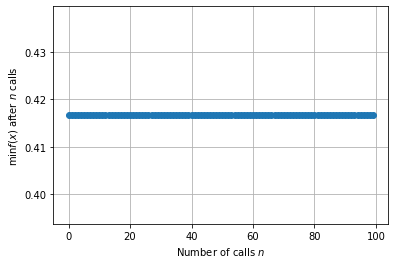

In [61]:
_ = optimizer._plot_convergence(original=True)